# Protein folding process analysis with MSM

In this tutorial, we demonstrate how to use the HTMD code for analysing a protein folding process, in this case, of the protein Villin.

To analyze, one needs MD trajectories first, which can be generated with HTMD. Here, we already provide the trajectories (data) to analyze. You can download the data from [here](http://pub.htmd.org/tutorials/protein-folding-analysis/datasets.tar.gz) (**Warning: 3GB filesize**)

Alternatively, you can download the dataset using `wget`.

In [ ]:
import os
assert os.system('wget -rcN -np -nH -q --cut-dirs=2 -R index.html* http://pub.htmd.org/tutorials/protein-folding-analysis/protein_folding_datasets/') == 0

## Getting started

First we import the modules we are going to need for the tutorial

In [1]:
from htmd.ui import *
from moleculekit.config import config

config(viewer='webgl')

2024-06-12 11:29:55,334 - numexpr.utils - INFO - Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2024-06-12 11:29:55,334 - numexpr.utils - INFO - NumExpr defaulting to 8 threads.



Please cite HTMD: Doerr et al.(2016)JCTC,12,1845. https://dx.doi.org/10.1021/acs.jctc.6b00049
HTMD Documentation at: https://software.acellera.com/htmd/

You are on the latest HTMD version (2.3.28+13.gc88a92d48.dirty).



## Creating a simulation list

For the purposes of an analysis, full atom information is required by HTMD. Therefore each simulation trajectory has to be associated with a corresponding PDB file. Additionally, if you plan to run adaptive, each trajectory needs to be associated with an input directory which contains the files used to run the simulations. The simList function allows us to make these associations

    sims = simlist(glob('data/*/'), glob('input/*/'), glob('input/*/'))

## Filtering trajectories

Typically waters are removed from the trajectories as they are not used in the analysis and it helps speed up further calculations. These filtered trajectories are written into a new directory. The advantage of filtering is that if your input structures only differ in the number of water molecules, you can produce a single unique pdb file for all simulations once you remove the waters, which will speed up calculations. This step is not necessary for the analysis and you can skip it if you don't mind the slowdown in calculations. In that case replace in the following commands the fsims variable with sims.

    fsims = simfilter(sims, './filtered/', filtersel='not water')

In this tutorial, in order for the trajectories to be downloaded in a timely manner, we provide only the filtered trajectories which are stored in three separate dataset folders. Therefore we will skip the above two commands and construct the simulation list directly from the filtered trajectories.

In [2]:
sets = glob('protein_folding_datasets/*/')
sims = []
for s in sets:
    fsims = simlist(glob(s + '/filtered/*/'), 'protein_folding_datasets/1/filtered/')
    sims = simmerge(sims, fsims)

Creating simlist: 100%|█████████████████████████████████████████████████████████████████████| 708/708 [00:09<00:00, 75.03it/s]


## Calculating metrics

To build a Markov state model we need to project the atom coordinates onto a lower dimensional space which can be used for clustering the conformations into a set of states. Here we have selected to use the carbon alpha atoms of the protein. This will calculate contacts between all carbon alpha atoms.

In [3]:
metr = Metric(sims)
metr.set(MetricSelfDistance('protein and name CA', metric='contacts', periodic='chains'))
data = metr.project()

Projecting trajectories: 100%|████████████████████████████████████████████████████████████| 2137/2137 [01:08<00:00, 31.13it/s]
2024-06-12 11:31:35,072 - htmd.projections.metric - INFO - Frame step 0.1ns was read from the trajectories. If it looks wrong, redefine it by manually setting the MetricData.fstep property.


Here we provide the frame-step in nanoseconds i.e. the time that passes between two consecutive frames in a trajectory. This is automatically read from the trajectories, however not all trajectories contain the correct fstep so it can be useful to manually define it like here.

In [4]:
data.fstep = 0.1

## Removing trajectories

Sometimes the set of trajectories can contain trajectories of incorrect length. These are typically corrupted trajectories and are removed.

The `plotTrajSizes` method plots all trajectory lengths sorted

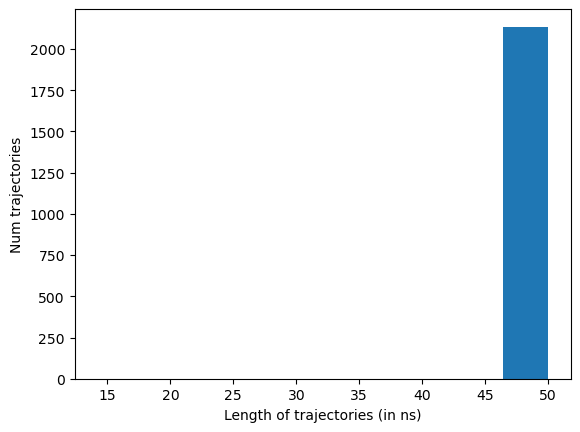

In [5]:
data.plotTrajSizes()

`dropTraj` has multiple options for removing simulations from the dataset. Here we use it to remove all trajectories whose length is not equal to the mode length. 

In [6]:
data.dropTraj()

2024-06-12 11:31:35,402 - htmd.metricdata - INFO - Dropped 7 trajectories from 2137 resulting in 2130


array([  89,  183,  682,  693,  720, 1597, 1901])

## TICA

TICA is a method that can be used to improve the clustering of the conformations. This is done by projecting the data onto a lower-dimensional space which separates well the metastable minima and places clusters on the transition regions. 

In [7]:
tica = TICA(data, 2, units='ns')
dataTica = tica.project(3)

## Bootstrapping

If we want to bootstrap our calculations we can at this point drop a random 20% of the trajectories and do the rest of the analysis multiple times to see if the results are consistent. Alternatively we can keep on using dataTica in the following commands. 

In [8]:
dataBoot = dataTica.bootstrap(0.8)

## Clustering conformations

Once we have cleaned the dataset we proceed to cluster the conformations.

Here we use the mini-batch kmeans clustering algorithm to produce 1000 clusters. 

In [9]:
dataBoot.cluster(MiniBatchKMeans(n_clusters=1000))

## Building the Markov model

After clustering it is time to build the Markov model.

In [10]:
model = Model(dataBoot)

Before constructing the Markov model we need to choose the lag-time at which it will be built. The lag-time is typically chosen by looking at the implied timescale (ITS) plot and selecting a lag-time at which the top timescales start converging. By constructing Markov models at various lag times HTMD creates a plot which shows the slowest implied timescales of each Markov model at various lag times. If a model is Markovian at a specific lag time, the implied timescales should stay unchanged for any higher lag times. Therefore, given an implied timescales plot, the user can monitor the convergence and choose the lag time at which to construct his Markov model, typically the Markov time which is the shortest lag time at which the timescales converge. Too large lag times can reduce the temporal resolution of the Markov model and can create more statistical uncertainty due to fewer transition counts and thus instability in the implied timescales. 

Estimating Timescales: 100%|██████████████████████████████████████████████████████████████████| 26/26 [00:36<00:00,  1.42s/it]


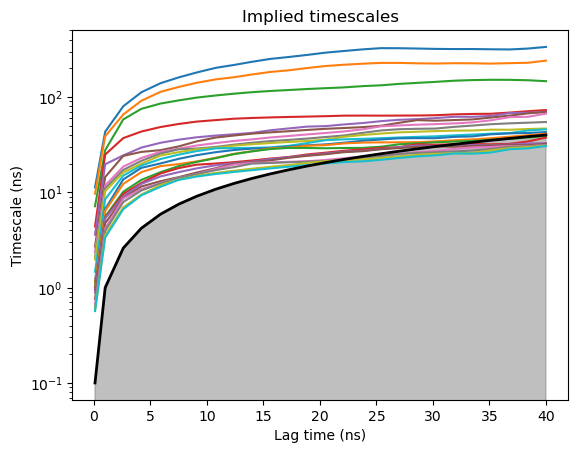

In [11]:
model.plotTimescales(maxlag=40, units="ns")

After seeing the ITS plot we decide on a lag-time of 25ns. A jump at the end of the timescales simply indicates that at such high lag times the statistics are unreliable and we can ignore the jump by picking the earliest lagtime where the ITS converge. Additionally the ITS plot showed us that there is a separation between 3 slow timescales and the rest of the timescales which are fast. Therefore we choose to lump our microstates together into 4 macrostates. 

In [12]:
model.markovModel(25, 4, units='ns')

2024-06-12 11:32:45,327 - htmd.model - INFO - 100.0% of the data was used
2024-06-12 11:32:45,423 - htmd.model - INFO - Number of trajectories that visited each macrostate:
2024-06-12 11:32:45,423 - htmd.model - INFO - [ 124  520   76 1644]


We can also visualize the equilibrium populations of each macrostate using the following command

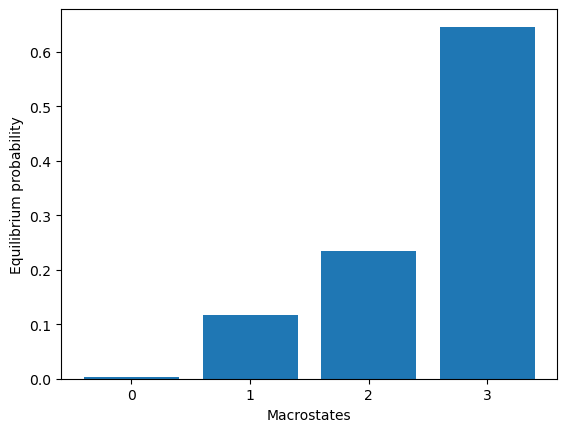

array([0.00261863, 0.11721313, 0.23426915, 0.64589909])

In [13]:
model.eqDistribution()

Once we have a Markov model we can plot the free energy surface by projecting it on any of our projected coordinates. For example to plot it on the first two TICA coordinates we call it like this.

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 451.43it/s]


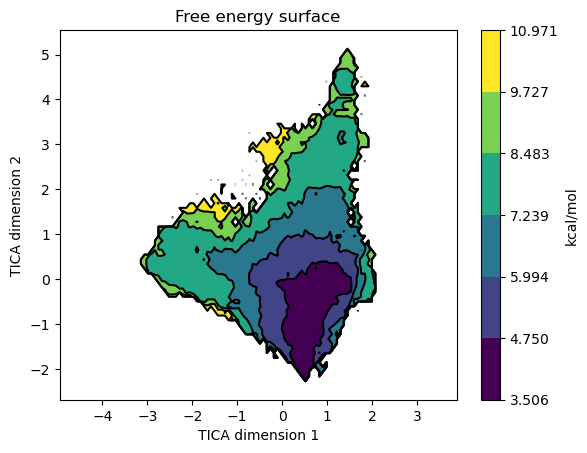

In [14]:
model.plotFES(0, 1, temperature=360)

We can also plot the micro and macrostates on top of the FES by setting `states=True`

100%|████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 432.36it/s]


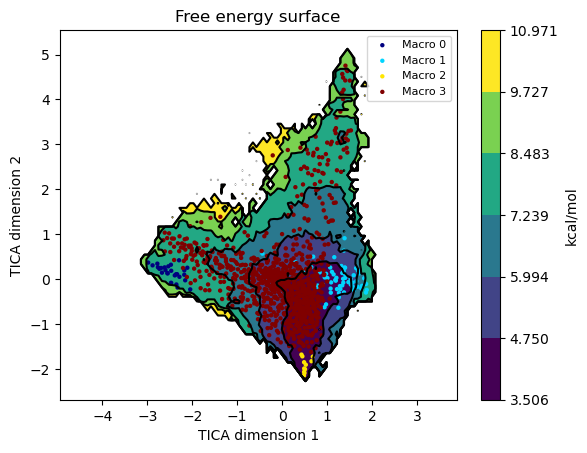

In [15]:
model.plotFES(0, 1, temperature=360, states=True)

## Visualizing the states

To see what the states look like we can use the `viewStates` method. We load the macrostates and add a protein representation.

In [16]:
model.viewStates(protein=True)

Getting state Molecules: 100%|██████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00, 47.68it/s]


NGLWidget()

## Calculating the kinetics

One of the major advantages of Markov state models is that they can provide quantitative results about the kinetics between states.

Provide the Kinetics constructor with the system temperature. It automatically then calculates the source and sink states.

In [17]:
kin = Kinetics(model, temperature=360)

2024-06-12 11:32:52,301 - htmd.kinetics - INFO - Detecting source state...
2024-06-12 11:32:52,730 - htmd.kinetics - INFO - Guessing the source state as the state with minimum contacts.
2024-06-12 11:32:52,731 - htmd.kinetics - INFO - Source macro = 3
2024-06-12 11:32:52,731 - htmd.kinetics - INFO - Detecting sink state...
2024-06-12 11:32:52,732 - htmd.kinetics - INFO - Sink macro = 2


To see the rates between the source and sink states we use the `getRates` method.

In [18]:
r = kin.getRates()
print(r)

2024-06-12 11:32:52,735 - htmd.kinetics - INFO - Calculating rates between source: [3] and sink: [2] states.


mfpton = 1.55E+03 (ns)
mfptoff = 2.75E+02 (ns)
kon = 6.46E+05 (1/M 1/s)
koff = 3.64E+06 (1/s)
koff/kon = 5.63E+00 (M)
kdeq = 2.76E+00 (M)
g0eq = 0.73 (kcal/M)



To plot the free energies and mean first passage times of all state use the `plotRates()` method.

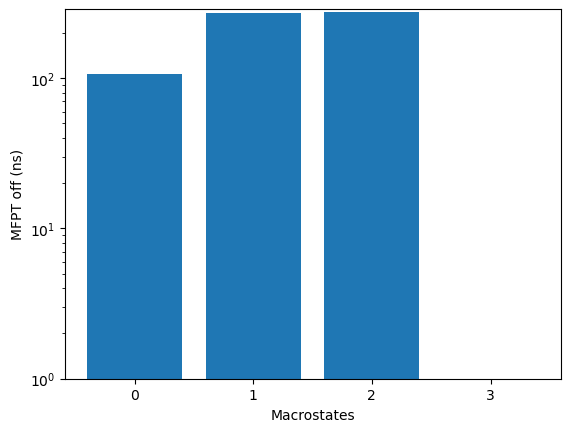

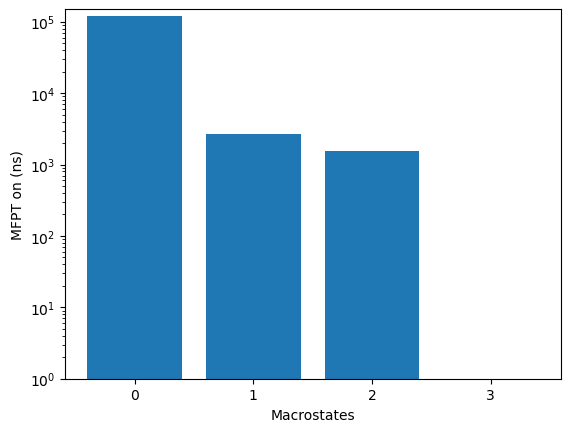

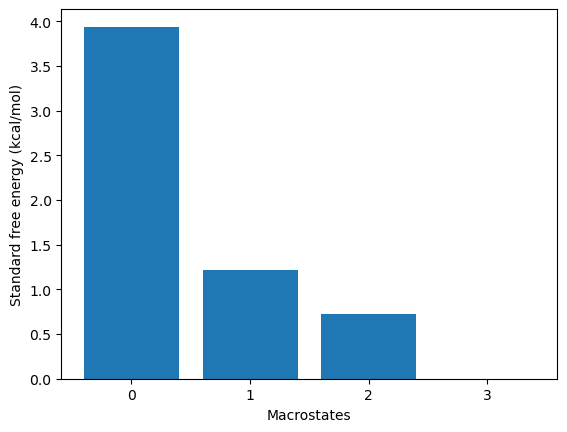

In [19]:
kin.plotRates()

To visualize the kinetic flux pathways between the source and sink states, use the `plotFluxPathways` method:

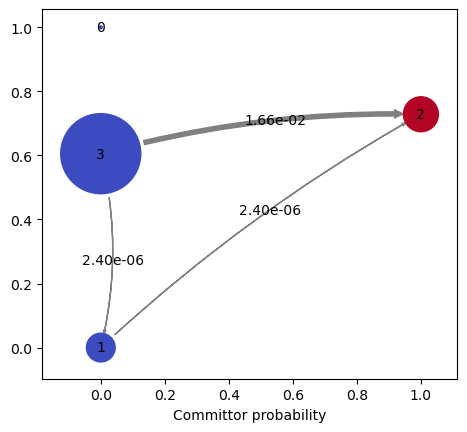

Path flux		%path	%of total	path
0.016626166724192558	100.0%	100.0%		[3 2]
2.4011990785474156e-06	0.0%	100.0%		[3 1 2]
2.2905710656725417e-11	0.0%	100.0%		[3 0 1 2]


In [20]:
kin.plotFluxPathways()

And this concludes the protein folding tutorial.